In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
# import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack
# import fitsio

from astropy import units as u
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.stats import binned_statistic

sys.path.append('/Users/rongpu/git/Python/user_modules/')
from user_common import extrap1d

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
sed_reorder = [2, 3, 4, 6, 5, 7, 1]

In [4]:
# # Filter curves from Legacy Surveys website
# bands = ['decam_g', 'decam_r', 'decam_z']
# filenames = ['decam.g.am1p4.dat.txt', 'decam.r.am1p4.dat.txt', 'decam.z.am1p4.dat.txt']
# plt.figure(figsize=(12, 10))
# for index in range(len(bands)):
#     band = bands[index]
#     # Load filter response curve
#     filename = filenames[index]
#     tmp = Table.read('/Users/rongpu/Data/desi_misc/extinction/filter_curves/'+filename, format='ascii')
#     wx = tmp['col1']
#     if 'decam' or 'mosaic' in band:
#         wy = tmp['col2']
#     else:
#         wy = tmp['col4']
#     plt.plot(wx, wy)
# plt.show()

In [5]:
# # Filter curves from EAZY
# bands = ['u', 'g', 'r', 'i', 'z', 'y']
# filters = {}
# for index in range(len(bands)):
#     band = bands[index]
#     tmp = Table.read('/Users/rongpu/Data/desi_misc/extinction/filter_curves/EAZY/DECam_{}.txt'.format(band), format='ascii.no_header')
#     wx = tmp['col2']
#     wy = tmp['col3']
#     # Interpolate filter response curve
#     filters[band] = extrap1d(wx, wy)
# plt.figure(figsize=(12, 10))
# plt.plot([], [], ' ', color='k', label="            R(g)     R(r)    R(z)")
# for index in range(len(bands)):
#     band = bands[index]
#     wx = np.linspace(3000, 11000, 2000)
#     plt.plot(wx, filters[band](wx))
# plt.show()

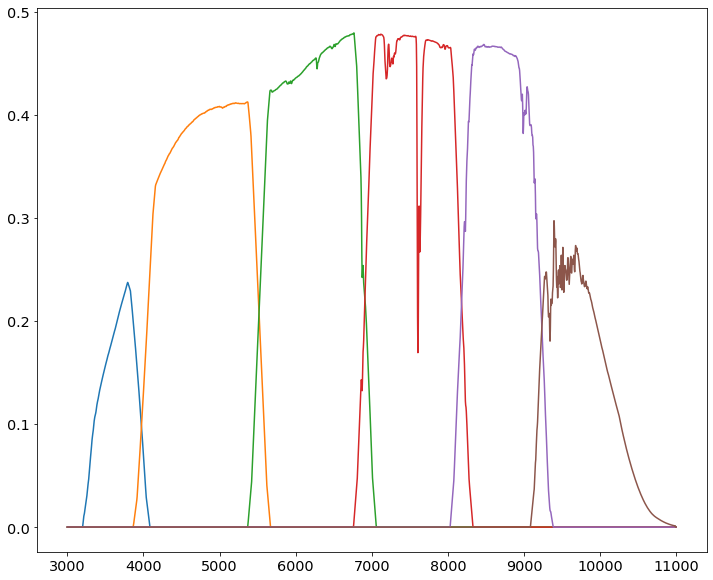

In [48]:
# Filter curves from https://github.com/lsst/throughputs/blob/main/baseline
bands = ['u', 'g', 'r', 'i', 'z', 'y']
filters = {}
for index in range(len(bands)):
    band = bands[index]
    tmp = Table.read('/Users/rongpu/Downloads/throughputs-main/baseline/total_{}.dat'.format(band), format='ascii.no_header')
    wave = tmp['col1'] * 10.  # nm -> angstrom
    throughput = tmp['col2']
    # Interpolate filter response curve
    filters[band] = extrap1d(wave, throughput)

plt.figure(figsize=(12, 10))
plt.plot([], [], ' ', color='k', label="            R(g)     R(r)    R(z)")
for index in range(len(bands)):
    band = bands[index]
    wave = np.linspace(3000, 11000, 2000)
    plt.plot(wave, filters[band](wave))
plt.show()

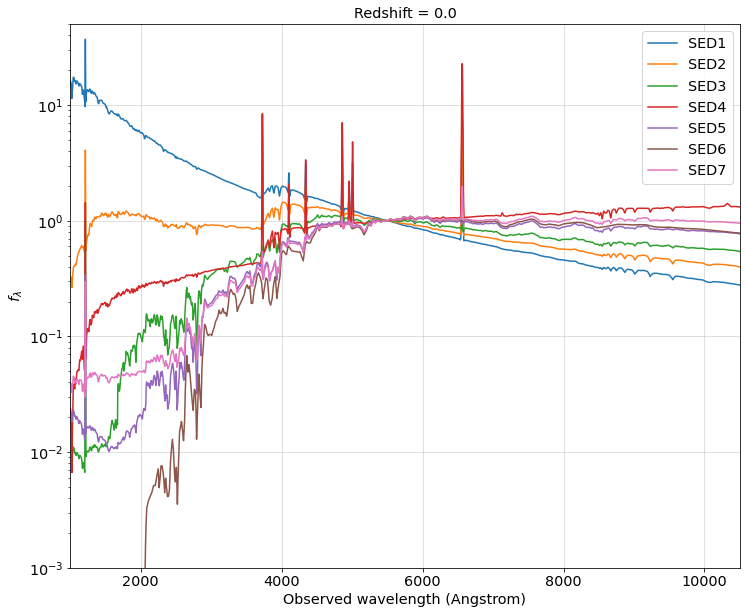

In [56]:
seds = {}
for sed_index in range(1, 8):
    # Galaxy spectrum f_lambda (in flux unit)
    fn = '/Users/rongpu/Data/desi_misc/extinction/templates/EAZY_v1.1_lines/eazy_v1.1_sed{}.dat'.format(sed_reorder[sed_index-1])
    tmp = Table.read(fn, format='ascii')
    wave, f_lambda = tmp['col1'], tmp['col2']    
    mask = (wave>1000) & (wave<11000)
    wave = wave[mask]
    f_lambda = f_lambda[mask]
    s_interp = extrap1d(wave, f_lambda)
    seds['SED{}'.format(sed_index)] = s_interp
    
plt.figure(figsize=(12, 10))
for sed_index in range(1, 8):
    wave = np.linspace(1000, 11000, 10001)
    f_lambda = seds['SED{}'.format(sed_index)](wave)
    f_norm = seds['SED{}'.format(sed_index)](5500)
    f_lambda = f_lambda/f_norm
    plt.plot(wave, f_lambda, label='SED{}'.format(sed_index))

# plt.plot(smooth_sx_star, smooth_sy_star, 'gray', linewidth=5, alpha=0.6, label='7000K star')
plt.title('Redshift = {:.1f}'.format(redshift))
plt.xlabel('Observed wavelength (Angstrom)')
plt.ylabel('$f_\lambda$')

plt.xlim(1000, 10500)
plt.ylim(1e-3, 5e1)
plt.yscale('log')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [67]:
redshifts = np.arange(0., 0.16, 0.005)

cat = Table()
cat['redshift'] = redshifts

# for sed_index in range(1, 8):
for sed_index in [7]:
    
    for band in bands:
        print('SED{} {}'.format(sed_index, band))
        mags = []
        for redshift_index, redshift in enumerate(redshifts):

            wave = np.linspace(3000, 11000, 8001)
            wave_rest = wave / (1+redshift)
            throughput = filters[band](wave)
            f_lambda = seds['SED{}'.format(sed_index)](wave_rest)
            f_nu_obs = throughput * f_lambda * wave**2
            f_nu_obs_interp = extrap1d(wave, f_nu_obs)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                flux = quad(f_nu_obs_interp, wave.min(), wave.max())[0] / quad(filters[band], wave.min(), wave.max())[0]
            mags.append(-2.5 * np.log10(flux))

        cat['SED{}_{}'.format(sed_index, band)] = mags

SED7 u
SED7 g
SED7 r
SED7 i
SED7 z
SED7 y


In [68]:
cat_default = cat.copy()

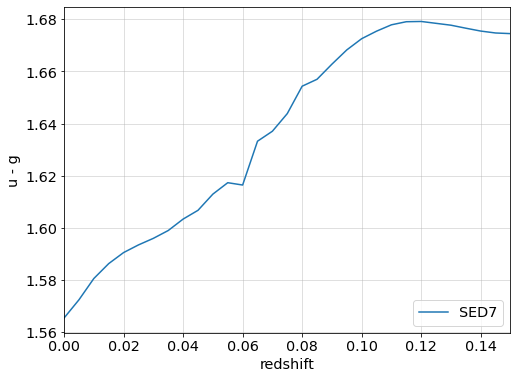

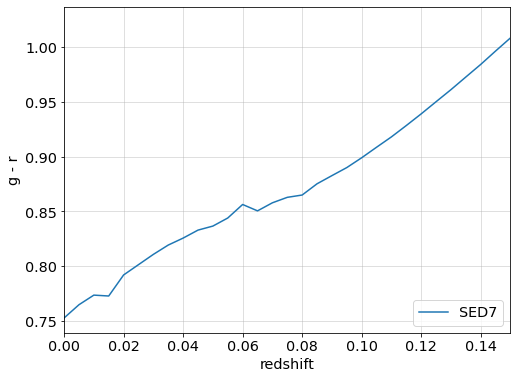

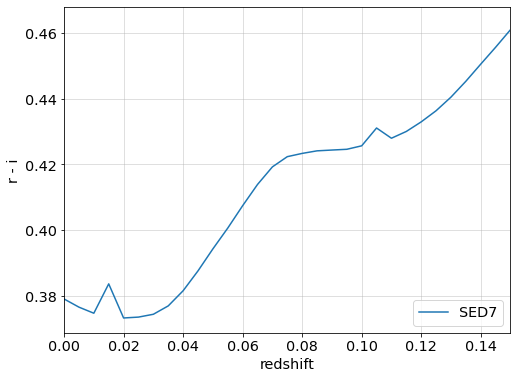

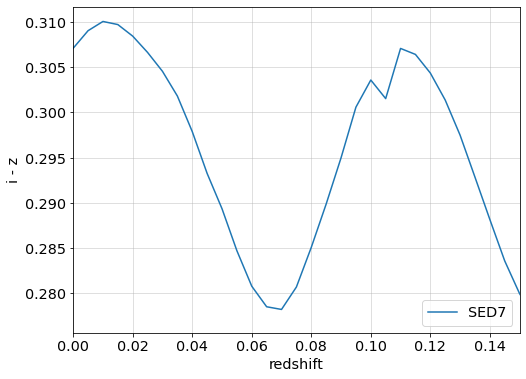

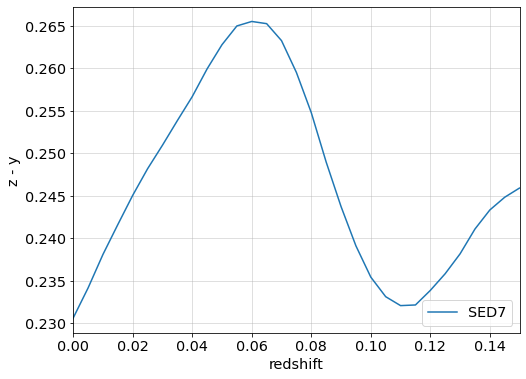

In [70]:
for color in ['ug', 'gr', 'ri', 'iz', 'zy']:
    plt.figure(figsize=(8, 6))
    # for sed_index in range(1, 8):
    for sed_index in [7]:
        plt.plot(cat['redshift'], cat['SED{}_{}'.format(sed_index, color[0])]-cat['SED{}_{}'.format(sed_index, color[1])], label='SED{}'.format(sed_index))
    plt.xlim(0, 0.15)
    plt.grid(alpha=0.5)
    plt.xlabel('redshift')
    plt.ylabel('{} - {}'.format(color[0], color[1]))
    plt.legend(loc='lower right')
    plt.show()